In [1]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

### 1 - Number Analysis with Dataset

In [3]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.types import BooleanType
from pyspark.sql.functions import pandas_udf
import pandas as pd

# Initialize Spark
spark = SparkSession.builder.appName("Number_Analysis_Extended").getOrCreate()

# Read CSV
nums = spark.read.option("header", True).option("inferSchema", True).csv("values.csv")

# Even and Odd split
even = nums.filter((F.col("Value") % 2) == 0)
odd = nums.filter((F.col("Value") % 2) != 0)

print("Evens:"); even.show()
print("Odds:"); odd.show()

# Statistics
stats = nums.agg(
    F.max("Value").alias("max_val"),
    F.min("Value").alias("min_val"),
    F.sum("Value").alias("sum_val"),
    F.round(F.avg("Value"), 2).alias("avg_val")
)
print("Stats:")
stats.show()

# -------- Vectorized Prime Check using pandas_udf --------
@pandas_udf(BooleanType())
def is_prime_pandas(series: pd.Series) -> pd.Series:
    def check_prime(n):
        if n is None or n < 2:
            return False
        if n == 2:
            return True
        if n % 2 == 0:
            return False
        i = 3
        while i * i <= n:
            if n % i == 0:
                return False
            i += 2
        return True
    return series.apply(check_prime)

# Apply vectorized UDF
primes = nums.filter(is_prime_pandas(F.col("Value")))
print("Primes:")
primes.show()

# -------- Palindromic Number Detection --------
@pandas_udf(BooleanType())
def is_palindrome(series: pd.Series) -> pd.Series:
    return series.astype(str).apply(lambda x: x == x[::-1])

palindromes = nums.filter(is_palindrome(F.col("Value")))
print("Palindromes:")
palindromes.show()

# -------- RDD Operations (for comparison) --------
rdd = nums.rdd.map(lambda row: row["Value"])
total_sum = rdd.reduce(lambda a, b: a + b)
even_count = rdd.filter(lambda x: x % 2 == 0).count()

print("RDD Summary:")
print("Sum =", total_sum, "Even Count =", even_count)


Evens:
+-----+
|Value|
+-----+
|    2|
|    4|
|   20|
+-----+

Odds:
+-----+
|Value|
+-----+
|    3|
|   17|
|  121|
+-----+

Stats:
+-------+-------+-------+-------+
|max_val|min_val|sum_val|avg_val|
+-------+-------+-------+-------+
|    121|      2|    167|  27.83|
+-------+-------+-------+-------+

Primes:
+-----+
|Value|
+-----+
|    2|
|    3|
|   17|
+-----+

Palindromes:
+-----+
|Value|
+-----+
|    2|
|    3|
|    4|
|  121|
+-----+

RDD Summary:
Sum = 167 Even Count = 3


### 2 - Logical Analysis on Age Data

People with Category:
+-----+---+--------+
| Name|Age|Category|
+-----+---+--------+
|Dhana| 29|   Adult|
| Ravi| 16|   Minor|
|  Anu| 64|  Senior|
|Meena| 45|   Adult|
|Kumar| 12|   Minor|
+-----+---+--------+

Count per Category:
+--------+-----+
|Category|count|
+--------+-----+
|  Senior|    1|
|   Minor|    2|
|   Adult|    2|
+--------+-----+

Oldest:
+----+---+
|Name|Age|
+----+---+
| Anu| 64|
+----+---+

Youngest:
+-----+---+
| Name|Age|
+-----+---+
|Kumar| 12|
+-----+---+

Median Age ≈ 29.0


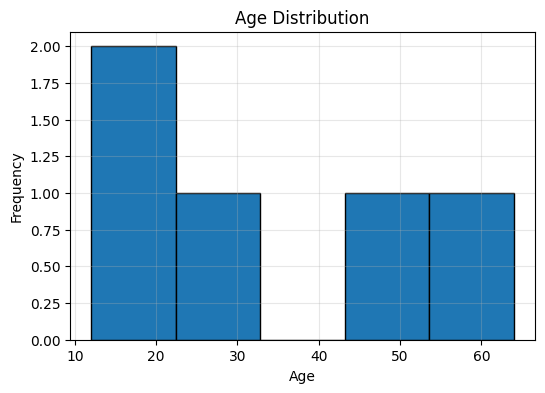

In [5]:
from pyspark.sql import SparkSession, functions as F
import matplotlib.pyplot as plt

# Initialize Spark
spark = SparkSession.builder.appName("People_Categorization_Extended").getOrCreate()

# Read data
people = spark.read.option("header", True).option("inferSchema", True).csv("persons.csv")

# 1️⃣ Categorize people
people_cat = people.withColumn(
    "Category",
    F.when(F.col("Age") < 18, "Minor")
     .when((F.col("Age") >= 18) & (F.col("Age") <= 59), "Adult")
     .otherwise("Senior")
)
print("People with Category:")
people_cat.show()

# 2️⃣ Count per category
print("Count per Category:")
counts = people_cat.groupBy("Category").count()
counts.show()

# 3️⃣ Oldest and Youngest
print("Oldest:")
oldest = people.orderBy(F.desc("Age")).limit(1)
oldest.show()

print("Youngest:")
youngest = people.orderBy(F.asc("Age")).limit(1)
youngest.show()

# 4️⃣ Median Age (approximate)
median_age = people.approxQuantile("Age", [0.5], 0.01)[0]
print(f"Median Age ≈ {median_age}")

# 5️⃣ Export for plotting (optional visualization)
pdf = people.toPandas()

# Plot age distribution
plt.figure(figsize=(6,4))
plt.hist(pdf["Age"], bins=5, edgecolor='black')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()


### 3 - Product Sales Analysis

In [6]:
from pyspark.sql import SparkSession, functions as F

# Initialize Spark
spark = SparkSession.builder.appName("Sales_Analysis_Extended").getOrCreate()

# Read CSV
sales = spark.read.option("header", True).option("inferSchema", True).csv("products.csv")

# 1️⃣ Compute Revenue per product
sales_with_rev = sales.withColumn("Revenue", F.col("Quantity") * F.col("Price"))
rev_per_product = sales_with_rev.groupBy("Product", "Category") \
    .agg(
        F.sum("Revenue").alias("total_revenue"),
        F.sum("Quantity").alias("total_qty")
    )

print("Revenue per Product:")
rev_per_product.orderBy(F.desc("total_revenue")).show()

# 2️⃣ Best-selling product and category
print("Best-Selling Product:")
best_product = rev_per_product.orderBy(F.desc("total_qty")).limit(1)
best_product.show()

print("Best-Selling Category:")
best_category = sales.groupBy("Category") \
    .agg(F.sum("Quantity").alias("category_qty")) \
    .orderBy(F.desc("category_qty")).limit(1)
best_category.show()

# 3️⃣ Products with sales below 100 units
print("Low-Sales Products (Total Qty < 100):")
low_sales_products = rev_per_product.filter(F.col("total_qty") < 100)
low_sales_products.show()

# -------------------------------------------------------------
# 4️⃣ Extension 1: Monthly revenue (if Date column exists)
# -------------------------------------------------------------
if "Date" in sales.columns:
    monthly_revenue = sales_with_rev.withColumn("Month", F.date_format(F.col("Date"), "yyyy-MM")) \
        .groupBy("Month") \
        .agg(F.sum("Revenue").alias("monthly_revenue")) \
        .orderBy("Month")
    print("Monthly Revenue:")
    monthly_revenue.show()
else:
    print("No 'Date' column found — skipping monthly revenue calculation.")

# -------------------------------------------------------------
# 5️⃣ Extension 2: Reorder suggestion (based on threshold)
# -------------------------------------------------------------
threshold = 50
reorder_suggestions = rev_per_product.withColumn(
    "Reorder_Required",
    F.when(F.col("total_qty") < threshold, "YES").otherwise("NO")
)

print("Reorder Suggestions:")
reorder_suggestions.orderBy("Product").show()

# -------------------------------------------------------------
# 6️⃣ (Optional) Save results to CSV
# -------------------------------------------------------------
reorder_suggestions.coalesce(1).write.mode("overwrite").option("header", True).csv("output/reorder_summary")

print("✅ Results saved to output/reorder_summary folder.")


Revenue per Product:
+--------+------------+-------------+---------+
| Product|    Category|total_revenue|total_qty|
+--------+------------+-------------+---------+
|    Rice|   Groceries|      20000.0|      500|
| Shampoo|PersonalCare|       9600.0|       80|
|   Sugar|   Groceries|       2700.0|       60|
|    Soap|PersonalCare|       2460.0|      120|
|Notebook|  Stationery|        750.0|       30|
+--------+------------+-------------+---------+

Best-Selling Product:
+-------+---------+-------------+---------+
|Product| Category|total_revenue|total_qty|
+-------+---------+-------------+---------+
|   Rice|Groceries|      20000.0|      500|
+-------+---------+-------------+---------+

Best-Selling Category:
+---------+------------+
| Category|category_qty|
+---------+------------+
|Groceries|         560|
+---------+------------+

Low-Sales Products (Total Qty < 100):
+--------+------------+-------------+---------+
| Product|    Category|total_revenue|total_qty|
+--------+----------